In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from train_test import train, test
import numpy as np
from torch.utils.data import Dataset 
import torch.nn.utils as utils
import time
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import Levenshtein as lev
import matplotlib.pyplot as plt

import seaborn as sns
import random

In [94]:
LETTER_LIST = ['<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ','<sos>','<eos>']

In [90]:
!nvidia-smi

Sat Dec  5 02:30:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 41%   37C    P2    68W / 280W |  12331MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:05:00.0 Off |                  N/A |
| 72%   87C    P2   251W / 280W |  22812MiB / 24220MiB |     94%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [92]:
!kill  17021  

In [95]:
def create_dictionaries(letter_list):
    letter2index = {}
    index2letter = {}
    for i in range(0,len(letter_list)):
        letter2index[letter_list[i]]=i
        index2letter[i]=letter_list[i]
    
    return letter2index, index2letter

letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [96]:
def load_data():
    speech_train = np.load('train.npy', allow_pickle=True, encoding='bytes')
    speech_valid = np.load('dev.npy', allow_pickle=True, encoding='bytes')
    speech_test = np.load('test.npy', allow_pickle=True, encoding='bytes')

    transcript_train = np.load('./train_transcripts.npy', allow_pickle=True,encoding='bytes')
    transcript_valid = np.load('./dev_transcripts.npy', allow_pickle=True,encoding='bytes')

    return speech_train, speech_valid, speech_test, transcript_train, transcript_valid

In [97]:
def transform_letter_to_index(transcript, letter_list):
    '''
    :param transcript :(N, ) Transcripts are the text input
    :param letter_list: Letter list defined above
    :return letter_to_index_list: Returns a list for all the transcript sentence to index
    '''
    letter_to_index_list = []
    l=[]
    for utterance in transcript:
        for word in utterance:
            for letter in word.decode('utf-8'):
                l.append(letter2index [letter])
            l.append(letter2index [' '])#Space between the words use letter2index
        l=l[:-1]
        l.append(letter2index ['<eos>'])#End of the sentence
        letter_to_index_list.append(l)
        l=[]
    return  letter_to_index_list

In [98]:
speech_train, speech_valid, speech_test, transcript_train, transcript_valid = load_data()
character_text_train = transform_letter_to_index(transcript_train, LETTER_LIST)
character_text_valid = transform_letter_to_index(transcript_valid, LETTER_LIST)

In [99]:
transcript_train[1]

array([b'and', b'not', b'able', b'to', b'understand', b'what', b'all',
       b'these', b'strange', b'hints', b'portended', b'we', b'had', b'a',
       b'specimen', b'of', b'his', b'nasty', b'temper', b'you', b'know',
       b'continued', b'bluff', b'yes', b'twice', b'now', b"we've",
       b'heard', b'him', b'tear', b'around', b'like', b'a', b'bull',
       b'in', b'a', b'china', b'shop'], dtype='|S10')

In [100]:
len(character_text_train)

28539

In [101]:
class Speech2TextDataset(Dataset):
    '''
    Dataset class for the speech to text data, this may need some tweaking in the
    getitem method as your implementation in the collate function may be different from
    ours. 
    '''
    def __init__(self, speech, text=None, isTrain=True):
        self.speech = speech
        self.isTrain = isTrain
        if (text is not None):
            self.text = text

    def __len__(self):
        return self.speech.shape[0]

    def __getitem__(self, index):
        if (self.isTrain == True):
            return torch.tensor(self.speech[index].astype(np.float32)), torch.tensor(self.text[index])
        else:
            return torch.tensor(self.speech[index].astype(np.float32))

In [102]:
def collate_train(batch_data):
    #This batch will contain the speech,speech len and the text,text len
    ### Return the padded speech and text data, and the length of utterance and transcript ###
    X=[]
    Xlen=[]
    Y=[]
    Ylen=[]
    #print("Length of batch data :",len(batch_data))
    for i in range(len(batch_data)):
        X.append(torch.tensor(batch_data[i][0]))
        Xlen.append(len(batch_data[i][0]))
        Y.append(torch.tensor(batch_data[i][1]))
        Ylen.append(len(batch_data[i][1]))
        
    Xpad=pad_sequence(X, batch_first=True)#(B, T, C) 
    Ypad=pad_sequence(Y, batch_first=True)#(B, T, C) 
    
    return Xpad,torch.tensor(Xlen),Ypad,torch.tensor(Ylen)

def collate_test(batch_data):
    ### Return padded speech and length of utterance ###
    X=[]
    Xlen=[]
    for i in range(len(batch_data)):
        X.append(torch.tensor(batch_data[i]))
        Xlen.append(torch.tensor(len(batch_data[i])))
        #print(len(batch_data[i]))
        
    Xpad=pad_sequence(X, batch_first=True)
    
    return Xpad,torch.tensor(Xlen)


In [103]:
train_dataset = Speech2TextDataset(speech_train, character_text_train)
val_dataset = Speech2TextDataset(speech_valid, character_text_valid)
test_dataset = Speech2TextDataset(speech_test, None, False)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_train)
valid_loader =  DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=collate_train)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_test)

In [104]:
len(test_dataset.__getitem__(1))

1117

In [105]:
len(train_loader)

223

In [106]:
len(valid_loader)

43

In [107]:
len(test_loader)

41

In [108]:
from torch.autograd import Variable
class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, dropout=0.5):
        # x': (B, L, C)
        if dropout == 0 or not self.training:
            return x
        mask = x.data.new(x.size(0), 1, x.size(2))
        mask = mask.bernoulli_(1 - dropout)
        mask = Variable(mask, requires_grad=False) / (1 - dropout)
        mask = mask.expand_as(x)
        
        return mask * x

In [109]:
class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, lens):
        '''
        :param query :(batch_size, hidden_size) Query is the output of LSTMCell from Decoder
        :param keys: (batch_size, max_len, encoder_size) Key Projection from Encoder
        :param values: (batch_size, max_len, encoder_size) Value Projection from Encoder
        :return context: (batch_size, encoder_size) Attended Context
        :return attention_mask: (batch_size, max_len) Attention mask that can be plotted 
        
        '''
        #print('query type :',type(query))
        # Compute (batch_size, max_len) attention logits. "bmm" stands for "batch matrix multiplication".
        # Input shape of bmm:  (batch_size, max_len, hidden_size), (batch_size, hidden_size, 1) 
        # Output shape of bmm: (batch_size, max_len, 1)
        #print("Shape of key:",key.shape)
        attention = torch.bmm(key, query.unsqueeze(2)).squeeze(2)
        
        
        # Create an (batch_size, max_len) boolean mask for all padding positions
        # Make use of broadcasting: (1, max_len), (batch_size, 1) -> (batch_size, max_len)
        mask = torch.arange(key.size(1)).unsqueeze(0) >= lens.unsqueeze(1)
        mask=mask.to(device)
        # Set attention logits at padding positions to negative infinity.
        attention.masked_fill_(mask, -1e9)
        
        # Take softmax over the "source length" dimension.
        attention = nn.functional.softmax(attention, dim=1)
        
        # Compute attention-weighted sum of context vectors
        # Input shape of bmm: (batch_size, 1, max_len), (batch_size, max_len, hidden_size) 
        # Output shape of bmm: (batch_size, 1, hidden_size)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)
        
        # attention vectors are returned for visualization
        return context, attention
        


In [110]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    The length of utterance (speech input) can be hundereds to thousands of frames long.
    The Paper reports that a direct LSTM implementation as Encoder resulted in slow convergence,
    and inferior results even after extensive training.
    The major reason is inability of AttendAndSpell operation to extract relevant information
    from a large number of input steps.
    '''
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.0):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1,dropout=dropout_rate, bidirectional=True,batch_first=True)
        self.lockdrop = LockedDropout()
        self.dropout=dropout_rate

    def forward(self, x):
        '''
        :param x :(N, T) input to the pBLSTM
        :return output: (N, T, H) encoded sequence from pyramidal Bi-LSTM 
        '''
        #First we unpack the sequence
        x_pad,x_len=utils.rnn.pad_packed_sequence(x,batch_first=True)
        #print("Shape of output after x_pad :",x_pad.shape)
        #Ensuting T is even
        #print("Dropout in pBLSTM :",self.dropout)
        x_pad = self.lockdrop(x_pad, self.dropout)
        x_pad=x_pad[:,:(x_pad.shape[1]//2)*2,:]
        #x_lens = x_lens.to(DEVICE) NOT SURE
        #print("Shape of output after x_pad :",x_pad.shape)
        
        #now we reshape the x_pad
        #x_pad=x_pad.reshape(x_pad.shape[0],x_pad.shape[1]//2,x_pad.shape[2]*2)
        x_pad = x_pad.contiguous().view(x_pad.shape[0],int(x_pad.shape[1]//2),x_pad.shape[2]*2)        

        #print("Shape of output after x_pad :",x_pad.shape)
        x_len=x_len//2

        #Now we pack this back to send it off to the LSTM
        x_pack = utils.rnn.pack_padded_sequence(x_pad, lengths=x_len, batch_first=True, enforce_sorted=False)

        output, _ = self.blstm(x_pack)
        
        return output

In [111]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key and value.
    Key and value are nothing but simple projections of the output from pBLSTM network.
    '''
    def __init__(self, input_dim, hidden_dim, value_size=128,key_size=128,dropout_rate=0.0,dropouti=0):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=256, num_layers=1, bidirectional=True,batch_first=True)
        #print("hidden dimension is :",hidden_dim)
        
        ### Add code to define the blocks of pBLSTMs! ###
        self.pBLSTM1=pBLSTM(hidden_dim*4, hidden_dim,dropout_rate=dropout_rate)#Can change it to 2
        self.pBLSTM2=pBLSTM(hidden_dim*4, hidden_dim,dropout_rate=dropout_rate)
        self.pBLSTM3=pBLSTM(hidden_dim*4, hidden_dim,dropout_rate=dropout_rate)
        
        #print(hidden_dim)
        #print(type(hidden_dim)
        
        self.key_network = nn.Linear(hidden_dim*2, value_size)
        self.value_network = nn.Linear(hidden_dim*2, key_size)
        
        self.dropout=dropouti
        self.lockdrop = LockedDropout()


    def forward(self, x, lens):
        #print("X shape :",x.shape)
        #print(lens)
        rnn_inp = utils.rnn.pack_padded_sequence(x, lengths=lens, batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(rnn_inp)
        
        outputs=self.pBLSTM1(outputs)#We get a packed sequence output 
        outputs=self.pBLSTM2(outputs)#We get a packed sequence output 
        outputs=self.pBLSTM3(outputs)#We get a packed sequence output 
        
        linear_input,encoder_lens = utils.rnn.pad_packed_sequence(outputs,batch_first=True)
        
        linear_input = self.lockdrop(linear_input, self.dropout)
        keys = self.key_network(linear_input)
        value = self.value_network(linear_input)

        return keys, value,encoder_lens


In [112]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step, 
    thus we use LSTMCell instead of LSLTM here.
    The output from the second LSTMCell can be used as query here for attention module.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, hidden_dim, value_size=128, key_size=128, isAttended=True):#isAttended was set to false originally
        super(Decoder, self).__init__()
        hidden_dim=key_size + value_size
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=0)#b,max_len,hidden_decoder
        self.lstm1 = nn.LSTMCell(input_size=768, hidden_size=256)#512,512
        self.lstm2 = nn.LSTMCell(input_size=256, hidden_size=key_size)#Why is this key size
        
        
        self.isAttended = isAttended
        if (isAttended == True):
            self.attention = Attention()

        self.character_prob = nn.Linear(key_size + value_size, vocab_size)
        self.value_size=value_size 
        self.embedding.weight=self.character_prob.weight
        
        
        self.fc1 = nn.Linear(256, 256)
        self.selu1 = nn.SELU()
        #self.bn1 = nn.BatchNorm1d(256)
        self.selu2 = nn.SELU()
        #self.bn2 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 256)
        
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.character_prob.bias.data.zero_()
        self.character_prob.weight.data.uniform_(-initrange, initrange)


    def forward(self, epoch,batch_idx,encoder_lens,teacherForcingRate,key, values, text=None, isTrain=True):
        '''
        :param key :( N,T, key_size) Output of the Encoder Key projection layer
        :param values: (N, T,value_size) Output of the Encoder Value projection layer
        :param text: (N, text_len) Batch input of text with text_length
        :param isTrain: Train or eval mode
        :return predictions: Returns the character perdiction probability 
        '''
        batch_size = key.shape[0]

        if (isTrain == True):
            max_len =  text.shape[1]
            embeddings = self.embedding(text)
        else:
            max_len = 600
            
        total_attention=[]
        predictions = []
        hidden_states = [None, None]
        prediction = torch.zeros(batch_size,1).to(device)#(torch.ones(batch_size, 1)*33).to(DEVICE)
        context = values[:, 0, :].reshape(values.size(0),values.size(2))
        teacherForcingRate=teacherForcingRate 
        
        for i in range(max_len):
            # * Implement Gumble noise and teacher forcing techniques 
            # * When attention is True, replace values[i,:,:] with the context you get from attention.
            # * If you haven't implemented attention yet, then you may want to check the index and break 
            #   out of the loop so you do not get index out of range errors. 
            
            if (isTrain):
                #We consider Teacher forcing at first
                #Then we check if i=0 or not
                tf = np.random.random()
                if tf > teacherForcingRate :
                    if i==0:
                        char_embed=self.embedding(torch.zeros(batch_size,dtype=torch.long).fill_(letter2index['<sos>']).to(device))
                        #print(torch.zeros(batch_size,dtype=torch.long).fill_(letter2index['<sos>']))
                    else:
                        #We use the ground truth
                        char_embed = embeddings[:,i-1,:].to(device)#Dimension is of B,1,hidden_dim
                else:
                    char_embed = self.embedding(prediction.argmax(dim=-1)).to(device)
                    
            else:
                #Then we check if i=0 or not
                if i==0:
                    char_embed=self.embedding(torch.zeros(batch_size,dtype=torch.long).fill_(letter2index['<sos>']).to(device))
                else:
                    #char_embed = torch.nn.functional.gumbel_softmax(prediction).mm(self.embedding.weight)
                    char_embed = self.embedding(prediction.argmax(dim=-1)).to(device)

                
            inp = torch.cat([char_embed, context], dim=1)#Char Embed dim:B,H_ and Context:B,hidden_dim
            hidden_states[0] = self.lstm1(inp, hidden_states[0])

            inp_2 = hidden_states[0][0]
            hidden_states[1] = self.lstm2(inp_2, hidden_states[1])

            ### Compute attention from the output of the second LSTM Cell ###
            output = hidden_states[1][0]
                        
            #if self.isAttended :
            context,masked_attention=self.attention(output,key,values, encoder_lens)
            total_attention.append(masked_attention.detach().cpu())
            
            output = self.selu1(self.fc1(output))
            context = self.selu2(self.fc2(context))
            context = context.to(device)

            prediction = self.character_prob(torch.cat([output, context], dim=1))#Dimension is of B,hidden_dim for context
                                                                                 #Dimension is of B,hidden_dim for context
            predictions.append(prediction.unsqueeze(1))
            
        if batch_idx+1==223:
            
            all_attentions = torch.stack(total_attention, dim=1)
            
            plt.clf()
            '''
            sns.heatmap(all_attentions[0,:,:])
            plt.show()
            print("all_attentions shape :",all_attentions.shape)
            '''
            fig = plt.figure()
            plt.imshow(all_attentions[0,:,:], cmap="hot")
            plt.show()
            #plt.imsave('./attention', fig, cmap='hot')
            plt.close()
            

        return torch.cat(predictions, dim=1)#This is B,T,Vocab_size

In [113]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, hidden_dim, value_size=128, key_size=128, isAttended=True):
        super(Seq2Seq, self).__init__()
        self.dropout_rate=0.2
        self.dropouti=0.2
        self.encoder = Encoder(input_dim,256,256,256,self.dropout_rate,self.dropouti)
        self.decoder = Decoder(vocab_size, hidden_dim,256,256)

    def forward(self, epoch,batch_idx,teacherForcingRate,speech_input, speech_len, text_input=None, isTrain=True):
        key, value, encoder_lens = self.encoder(speech_input, speech_len)
        if (isTrain == True):
            predictions = self.decoder(epoch,batch_idx,encoder_lens,teacherForcingRate,key, value, text_input,isTrain=True)
        else:
            predictions = self.decoder(epoch,batch_idx,encoder_lens,None,key, value, text=None, isTrain=False)
        return predictions

In [114]:
#now we should build the model
model = Seq2Seq(input_dim=40, vocab_size=len(LETTER_LIST), hidden_dim=128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='none')
nepochs = 30

In [149]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('./checkpoint_final/Model_attention_Final2_52.pth')#Resnet_50_checkpoint
model.load_state_dict(checkpoint)
model.to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(40, 256, batch_first=True, bidirectional=True)
    (pBLSTM1): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (pBLSTM2): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (pBLSTM3): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (lockdrop): LockedDropout()
    )
    (key_network): Linear(in_features=512, out_features=256, bias=True)
    (value_network): Linear(in_features=512, out_features=256, bias=True)
    (lockdrop): LockedDropout()
  )
  (decoder): Decoder(
    (embedding): Embedding(35, 512, padding_idx=0)
    (lstm1): LSTMCell(768, 256)
    (lstm2): LSTMCell(256, 256)
    (attention): Attention()
    (character_prob): Linear(in_features=512, out_features=35, bias=True)
    (fc1): Linear(in_features=256, out_features=

In [150]:
#For predictions
def predictions(pred):
    sentence_full=[]
    for sentence in pred:#Taking every sentence
        sent=''
        for char in sentence:
            if char==33 or char==34:
                #print(char)
                break
            else:
                sent+=index2letter[char]
        sentence_full.append(sent)
    return sentence_full

In [151]:
#For computing the distance
def LevScore(preds, targets):
    res = 0.0
    for i in range(len(preds)):
        dist = lev.distance(preds[i], targets[i])
        res += dist
        
    return res#Average Levenstein Distance over the batch

In [135]:
def train(model, train_loader, criterion, optimizer, epoch, teacherForcingRate):
    model.train()
    model.to(device)
    
    # 1) Iterate through your loader
    train_loss=0
    
    
    for batch_idx,(inp,inp_len,target,target_len) in enumerate(train_loader):
        start = time.time()
        
        # 2) Use torch.autograd.set_detect_anomaly(True) to get notices about gradient explosion
        
        # 3) Set the inputs to the device.
        inp,inp_len,target=inp.to(device),inp_len.to(device),target.to(device)
        optimizer.zero_grad()
        
        # 4) Pass your inputs, and length of speech into the model.
        output=model(epoch,batch_idx,teacherForcingRate,inp, inp_len, target,True)
        
        mask = torch.arange(max(target_len)).unsqueeze(0) >= target_len.int().unsqueeze(1)#Switching Masks
        mask=mask.to(device)
        #mask = generate_mask(target_len).to(device)

        output.contiguous()
        # 6) If necessary, reshape your predictions and origianl text input 
        # 6.1) Use .contiguous() if you need to. 

        # 7) Use the criterion to get the loss.
        loss=criterion(output.view(-1,output.shape[2]),target.contiguous().view(-1))
        
        # 8) Use the mask to calculate a masked loss. 
        #masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)
        loss.masked_fill_(mask.contiguous().view(-1),0)
        
        loss=loss.mean()
        
        # 9) Run the backward pass on the masked loss. 
        loss.backward()
        # 10) Use torch.nn.utils.clip_grad_norm(model.parameters(), 2)
        torch.nn.utils.clip_grad_norm(model.parameters(), 2)

        # 11) Take a step with your optimizer
        optimizer.step()
        # 12) Normalize the masked loss
        train_loss+=loss.item()

        # 13) Optionally print the training loss after every N batches
        del inp
        del inp_len
        del target
        del target_len
        stop = time.time()
        torch.cuda.empty_cache()
        
        print('B: %d / %d, avg_loss: %.3f, Time Taken : %.3f, ' % (batch_idx+1, len(train_loader),train_loss/(batch_idx+1),stop-start),end='\n ')
    
        torch.save(model.state_dict(), "./checkpoint_final/Model_attention_Final2_{}.pth".format(epoch+1))

def validation(model, valid_loader):
    valid_loss=0
    total_dist_score=0
    model.eval()
    seq_len=0
    dist_score=0
    seq_len=0
    
    for batch_idx,(inp,inp_len,target,target_len) in enumerate(valid_loader):
        start = time.time()
        inp,inp_len,target=inp.to(device),inp_len.to(device),target.to(device)
        
        output=model(epoch,batch_idx,None,inp, inp_len, None, False)
        pred=predictions(output.argmax(-1).detach().cpu().numpy())#We get back batch of characters
        target=predictions(target.detach().cpu().numpy())#We get back batch of characters
        
        print("prediciton :",pred[0])
        print("Target : ",target[0])
        dist_score+= LevScore(pred,target)
        seq_len+=len(pred)#This is the batch size
        
        del inp
        del inp_len
        del target
        del target_len
        stop = time.time()
        torch.cuda.empty_cache()
    print('Distance Score: %.3f ' % (dist_score/seq_len),end='\n ')

In [136]:
start_epoch=49

Teacher Forcing : 0.2


<ipython-input-102-6392f1eef40b>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X.append(torch.tensor(batch_data[i][0]))
<ipython-input-102-6392f1eef40b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y.append(torch.tensor(batch_data[i][1]))
<ipython-input-135-6a0bef6e710b>:41: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 2)


B: 1 / 223, avg_loss: 0.072, Time Taken : 1.934, 
 B: 2 / 223, avg_loss: 0.079, Time Taken : 2.290, 
 B: 3 / 223, avg_loss: 0.084, Time Taken : 2.312, 
 B: 4 / 223, avg_loss: 0.083, Time Taken : 2.451, 
 B: 5 / 223, avg_loss: 0.085, Time Taken : 2.258, 
 B: 6 / 223, avg_loss: 0.084, Time Taken : 2.113, 
 B: 7 / 223, avg_loss: 0.084, Time Taken : 2.226, 
 B: 8 / 223, avg_loss: 0.086, Time Taken : 2.376, 
 B: 9 / 223, avg_loss: 0.085, Time Taken : 2.376, 
 B: 10 / 223, avg_loss: 0.085, Time Taken : 2.228, 
 B: 11 / 223, avg_loss: 0.084, Time Taken : 2.403, 
 B: 12 / 223, avg_loss: 0.084, Time Taken : 2.500, 
 B: 13 / 223, avg_loss: 0.084, Time Taken : 2.317, 
 B: 14 / 223, avg_loss: 0.084, Time Taken : 2.164, 
 B: 15 / 223, avg_loss: 0.084, Time Taken : 2.279, 
 B: 16 / 223, avg_loss: 0.085, Time Taken : 2.311, 
 B: 17 / 223, avg_loss: 0.085, Time Taken : 2.426, 
 B: 18 / 223, avg_loss: 0.085, Time Taken : 2.161, 
 B: 19 / 223, avg_loss: 0.085, Time Taken : 2.270, 
 B: 20 / 223, avg_loss

<Figure size 432x288 with 0 Axes>

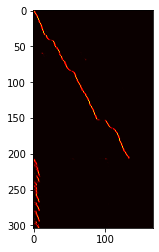

B: 223 / 223, avg_loss: 0.090, Time Taken : 2.339, 
 prediciton : this is they using a bentrary was closed our exploits
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with solic starty that had she been burning with ways of his late behaviour she must have forgiven him for the regret which he so forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old sons seemed centred in his eyes which became bloodshot we vance of the throat swelled his cheeks and temples became purple as though he was struck with uppellecy nothing was wanting to complete this but the other answered a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temples be

<Figure size 432x288 with 0 Axes>

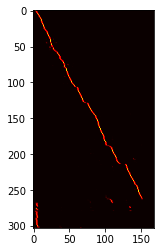

B: 223 / 223, avg_loss: 0.087, Time Taken : 2.330, 
 prediciton : this is they using a venture which closed our exploise
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with solic soluty that had she been burning with rage of his late behavior she must have forgiven him for the regret which he so forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old soul and seemed centred in his eyes which became blood shot revenge of the throat swelled his cheeks and temples became purple as though he was struck with up looks nothing was wanting to complete this but the utterance of a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temples b

<Figure size 432x288 with 0 Axes>

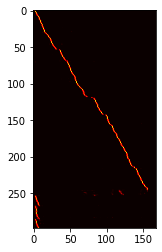

B: 223 / 223, avg_loss: 0.088, Time Taken : 2.628, 
 prediciton : this is the using a bentury was closed our explais
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with solic soulty that had she been borneing with wage of his late behavior she must have forgiven him for the regret which he so forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old soul seemed centred in his eyes which became blood chot we vangs of the throat swelled his cheeks and temples became purple as though he was struck with epoloxy nothing was wanting to complete this but the utterance of a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temples became p

<Figure size 432x288 with 0 Axes>

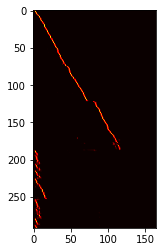

B: 223 / 223, avg_loss: 0.084, Time Taken : 2.419, 
 prediciton : this is the using abentral was closed our exploits
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with select similarity but had she been burning with wage of his late behaviour she must have forgiven him for the regret which he so forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old sonsseem centred in his eyes which became blunt shot le vangs of the throat swelled his cheeks and temples became purple as though he was struck with uppellecy nothing was wanting to complete this but the utterance of a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temples becam

<Figure size 432x288 with 0 Axes>

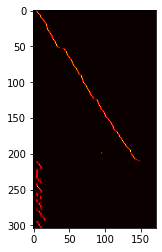

B: 223 / 223, avg_loss: 0.099, Time Taken : 2.388, 
 prediciton : this is the using a benture was closed our exploits
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with so much so alter that had she been born in with rage of his late behaviour she must have forgiven him for the regret which he so forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old sense centred in his eyes which became bloodshot the vanes of the throat swelled his cheeks and temples became purple as though he was struck with uppellecy nothing was wanting to complete this but the otterance of a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temples became 

<Figure size 432x288 with 0 Axes>

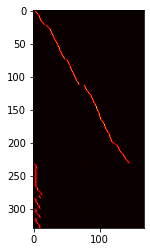

B: 223 / 223, avg_loss: 0.083, Time Taken : 2.669, 
 prediciton : this is the using a venture was closed our exploits
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with so like some holidy that had she been burning with rage of his late behaviour she must have forgiven him for the regret which he so forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old sonsein centred in his eyes which became bloodshot the vanes of the throat swelled his cheeks and temples became purple as though he was struck with up lexie nothing was wanting to complete this but the utterance of a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temples bec

<Figure size 432x288 with 0 Axes>

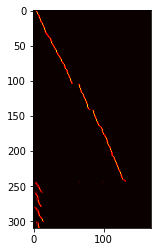

B: 223 / 223, avg_loss: 0.081, Time Taken : 2.562, 
 prediciton : this is the using a bentre was closed our explaints
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with so much some holidy that had she been broken with rage of his late behaviour she must have forgiven him for the regret which he so forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old sounds seemed centred in his eyes which became blood shot levensed of the throat swelled his cheeks and temples became purple as though he was struck with pellupsy nothing was wanting to complete this but the utterance of a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temple

<Figure size 432x288 with 0 Axes>

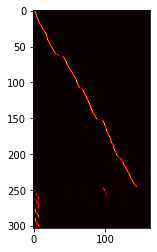

B: 223 / 223, avg_loss: 0.078, Time Taken : 2.233, 
 prediciton : this is the amusing abentry when closed our explaints
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with so much sysarty but had she been burning with wages of his late behaviour she must have forgiven him for the regret which he so forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old sonsscene centred in his eyes which became bloodshot revenge of the throat swelled his cheeks and temples became purple as though he was struck with pellupsy nothing was wanting to complete this but the otterance of a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temples becam

<Figure size 432x288 with 0 Axes>

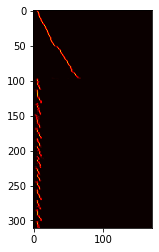

B: 223 / 223, avg_loss: 0.078, Time Taken : 2.465, 
 prediciton : this is the using abentry was clothes our explace
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with so much some arty that had she been boring with ways of his late behaviour she must have forgiven him for the regret which he so forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old sons seemscentered in his eyes which became bloodhot levense of the throat swelled his cheeks and temples became purple as though he was struck with pelixy nothing was wanting to complete this but the utterance of a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temples became pur

<Figure size 432x288 with 0 Axes>

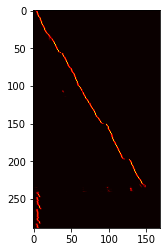

B: 223 / 223, avg_loss: 0.077, Time Taken : 2.269, 
 prediciton : this is the using abentry was closed our explaints
Target :  this is the amusing adventure which closed our exploits
prediciton : what he said he looked with so much sympority that had she been browing with rage of his late behaviour she must have forgiven him for the regret which he serve forcibly expressed
Target :  what he said he looked with so much sincerity that had she been burning with rage at his late behaviour she must have forgiven him for the regret which he so forcibly exprest
prediciton : at this moment the whole soul of the old sons seemed centred in his eyes which became bloodshot levans of the throat swelled his cheeks and temples became purple as though he was struck with up lipsy nothing was wanting to complete this but the utterance of a cry
Target :  at this moment the whole soul of the old man seemed centred in his eyes which became bloodshot the veins of the throat swelled his cheeks and temples be

In [137]:
teacherForcingRate=[0.05,0.10,0.15,0.20]#No batchnorm aand SELU activation function
for epoch in range(start_epoch,start_epoch+10):#New architecture with Encoder hidden dim=256 and Decoder hidden_dim=512 increased and encoder output increased
    
    tf=teacherForcingRate[0]
    if (epoch+1)>=15:
        tf=teacherForcingRate[1]
    if (epoch+1)>=20:
        tf=teacherForcingRate[2]
    if (epoch+1)>=30:
        tf=teacherForcingRate[3]
        
    print("Teacher Forcing :",tf)
    
    train(model, train_loader, criterion, optimizer, epoch,tf)
    validation(model, valid_loader)
  

In [139]:
start_epoch=epoch
start_epoch

58

In [152]:
def test(model, test_loader):
    ### Write your test code here! ###
    total_dist_score=0
    model.eval()
    seq_len=0
    final_prediction=[]
    for batch_idx,(inp,inp_len) in enumerate(test_loader):
        start = time.time()
        inp,inp_len=inp.to(device),inp_len.to(device)
        output=model(epoch,batch_idx,None,inp, inp_len, None, False)
        
        pred=predictions(output.argmax(-1).detach().cpu().numpy())#We get back batch of characters
        print(pred)
        for i in pred:
            final_prediction.append(i)
                
        del inp
        del inp_len
        stop = time.time()
        torch.cuda.empty_cache()
        print('B: %d / %d' % (batch_idx+1, len(test_loader)),end='\n ')
        
    return final_prediction

In [153]:
final_prediction=test(model, test_loader)

<ipython-input-102-6392f1eef40b>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X.append(torch.tensor(batch_data[i]))


['it has been my privilege to tread the soil of many lanes to observe the customs and studied aheabods of more nations would one and i get the fine their place in meet the people where and with whom the purity of man and woman his held more precious that among the malight mormans in a none and valleys of the west', 'we believe it a little resiraction and an actual hereafter and with future states shall be recognised every saint defied it awhirrise relationshipped histing huroner of peredant child better in sister husband in life', 'loreover had the people been inclined to rebellion while good or opportunity good they have wished', 'what the letter that shades calls a lest rerege his characteristic of the church and these invery general practice but of solecter marriage porality wise was of incident never uneasential', "and so the sorry mormonism one's on its fataliah has not yet been written the colyant press pessands continuously louistatives of its plagress new developments of its pl

In [154]:
len(final_prediction)

2620

In [155]:
import pandas as pd
sample_csv=pd.read_csv('/home/ironman/shayeree/records/hw4/11-785-fall-20-homework-4-part-2/hw4p2/sample.csv')

#We read in the sample csv and replace its last column with the scores we have achieved
n = sample_csv.columns[1]
sample_csv[n] = final_prediction

submission_csv=sample_csv

submission_csv.to_csv('/home/ironman/shayeree/records/hw4/11-785-fall-20-homework-4-part-2/hw4p2/sample19.csv',index=False) 